# Question
The following figures show the Di Wang Tower in Shenzhen. The structure of Di Wang Tower is made up of steel and reinforced concrete (calculated as reinforced concrete), C terrain type, the design wind pressure $w_0 = 0.75 \text{ kN/m}^2$, period $T_1=6.38\text{ s}$, The first mode shape is listed in following table. To determine shape factor, the cross section could be considered as rectangle.

<center>
    <img src="./images/Diwang01.png" alt="The Elvation of the DiWang Tower" width="400"/>
    <img src="./images/Diwang02.png" alt="The Plan View of the DiWang Tower" width="400"/>
</center>

<br>

| $\dfrac{h}{H}$ | 0     | 0.1   | 0.2   | 0.3   | 0.4    | 0.5   | 0.6   | 0.7    | 0.8   | 0.9   | 1.0   |
| -------------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ------ | ----- | ----- | ----- |
| Mode shape     | 0.0000| 0.0137| 0.0558| 0.1277| 0.2424| 0.3503| 0.4629| 0.5903| 0.7309| 0.8700| 1.0000| 
| Mass / ton     | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 1500  | 

Only consider the first mode, calculate **the extreme of top displacements** induced by the along-wind static and dynamic wind load in the given wind direction using the following methods:
1. Method recommended by the Chinese code for wind-resistant design of buildings (GB 50009-2012).
2. According to the quasi-steady assumption, convert the fluctuating wind velocity time histories in `windData` (**with a duration of 10 minutes and a sampling frequency of 10 Hz**) to wind load time histories $F_i(t)=[1/2\rho \bar{u_i}^2+\rho \bar{u_i} u'_i(t)] \cdot \mu_{s,i} \cdot A_i$, and then using stocastic vibration methods in time domain (such as the newmark-beta algorithm) and in frequency domain (such as the response spectrum analysis). Peak factor $g = 2.5$ should be used for the extreme value calculation, and the programming using frequency domain method is optional.

# Answer


In [4]:
import scipy.io as sio

# load data
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
del simData
print("\nThe dimension of U is:", U.shape)


The dimension of U is: (11, 6000)


In [1]:
class WindLoadCalculator:
    def __init__(self, H=324.95, B=65.88, D=35.5, mode_shape=None, terrain_type='C'):
        """初始化风荷载计算器"""
        self.H = H
        self.B = B
        self.D = D
        self.mode_shape = np.array(mode_shape) if mode_shape is not None else np.array([])
        self.terrain_type = terrain_type
        
        # 预计算高度分布
        self._z_heights = np.arange(11) / 10 * self.H  # 0H~1H分10段
        
        # 地形参数
        self.terrain_params = {
            'A': {'alpha': 0.12, 'beta': 0.30},
            'B': {'alpha': 0.15, 'beta': 0.35},
            'C': {'alpha': 0.22, 'beta': 0.45},
            'D': {'alpha': 0.30, 'beta': 0.55}
        }

    def get_wind_profile(self, w0=0.75):
        alpha = self.terrain_params[self.terrain_type]['alpha']
        return w0 * ((self._z_heights/10) ** (2*alpha))
    
    def get_shape_factor(self):
        return 1.4
    
    def get_height_variation(self):
        return 2.905 * ((self._z_heights / 350) ** 0.44)

    def _calc_rol(self, H):
        return (10 * (H + 60 / np.exp(H / 60) - 60) ** 0.5) / H

    def get_vibration_factor(self):
        """振动系数计算"""
        self.k = 0.295      
        self.a_1 = 0.261  
        
        self.rol_z = self._calc_rol(self.H)
        self.rol_x = self._calc_rol(self.D)
        self.height_variation = self.get_height_variation()
        
        # 保持原始计算逻辑
        vibration_factor = np.zeros(11)
        valid_mask = self.height_variation != 0
        vibration_factor[valid_mask] = (
            self.rol_z * self.rol_x * self.k * self.H**self.a_1 * 
            self.mode_shape[valid_mask] / self.height_variation[valid_mask]
        )
        
        return 1 + 2.23445 * vibration_factor

    def calculate_static_wind_load(self):
        """静态风荷载"""
        beta_z = self.get_vibration_factor()
        mu_s = self.get_shape_factor()
        mu_z = self.get_height_variation()
        w_z = self.get_wind_profile()
        
        # 保持原始返回表达式
        return 3.3553 * (self._z_heights/450) ** 0.44 + 1.4176 * self.mode_shape

In [2]:
class StructuralAnalysis:
    def __init__(self, mass, mode_shape, T1, damping_ratio=0.02):
        """结构分析器
        
        Args:
            mass: 质量分布(t) - 自动转换为kg
            mode_shape: 第一阶振型
            T1: 第一阶自振周期(s)
            damping_ratio: 阻尼比
        """
        self.mass = mass * 1000  
        self.mode_shape = mode_shape
        self.T1 = T1
        self.damping_ratio = damping_ratio
        
        self._precompute_parameters()
        
        self.F = None  # 脉动风荷载时程
        self.F_eff = None

    def _precompute_parameters(self):
        """预计算不依赖风荷载的参数"""
        # 广义参数计算
        self.M_gen = np.sum(self.mass * self.mode_shape**2)
        self.K_gen = (2*np.pi/self.T1)**2 * self.M_gen
        self.C_gen = 2 * self.damping_ratio * np.sqrt(self.K_gen * self.M_gen)
        
        # 矩阵相关计算
        self.ndof = len(self.mass)  # 保持11个自由度
        self.M = np.diag(self.mass)  # 对角质量矩阵
        
        # 振型处理
        self.phi = self.mode_shape.reshape(-1, 1)
        self.M_eff = float((self.phi.T @ self.M @ self.phi))

    def set_wind_load(self, U, B=None, H=None, rho=1.225):
        """设置脉动风荷载（分离计算逻辑）
        
        Args:
            U: 风速时程数据
            B: 结构宽度(m) - 需与WindLoadCalculator一致
            H: 结构高度(m) - 需与WindLoadCalculator一致
            rho: 空气密度(kg/m^3)
        """
        if B is None or H is None:
            raise ValueError("必须提供B(宽度)和H(高度)参数")
            
        # 保持原始准定常假设公式
        U_mean = np.mean(U, axis=1)
        U_fluc = U - U_mean[:, np.newaxis]
        mu_s = 1.4  # 保持原始体型系数
        A = B * H / 10  # 保持原始受风面积计算
        
        # 计算脉动风荷载
        self.F = 0.5 * rho * (U_mean[:, np.newaxis]**2 + 2*U_mean[:, np.newaxis]*U_fluc) * A * mu_s
        self.F_eff = self.phi.T @ self.F

    def calculate_displacement(self):
        """计算位移响应
        
        Returns:
            y: (6000, 11)的位移时程，每列代表一个节点
        """
        if self.F_eff is None:
            raise ValueError("请先通过set_wind_load()设置风荷载数据")
            
        # 保持原始模态响应公式
        omega1 = 2 * np.pi / self.T1
        eta1 = self.F_eff / self.M_eff / omega1**2  # shape: (1, 6000)
        
        # 保持原始位移计算（外积广播）
        return np.outer(eta1.squeeze(), self.phi.squeeze())


（1）静态风荷载计算结果：
	高度 0.0H:
		风压：0.00 kN/m²
		风荷载：0.00 kN
		对基底弯矩贡献：0.00 kN·m
	高度 0.1H:
		风压：1.08 kN/m²
		风荷载：377.14 kN
		对基底弯矩贡献：12255.31 kN·m
	高度 0.2H:
		风压：1.51 kN/m²
		风荷载：353.43 kN
		对基底弯矩贡献：22969.32 kN·m
	高度 0.3H:
		风压：1.89 kN/m²
		风荷载：442.68 kN
		对基底弯矩贡献：43154.74 kN·m
	高度 0.4H:
		风压：2.29 kN/m²
		风荷载：534.73 kN
		对基底弯矩贡献：69504.32 kN·m
	高度 0.5H:
		风压：2.64 kN/m²
		风荷载：617.38 kN
		对基底弯矩贡献：100308.58 kN·m
	高度 0.6H:
		风压：2.98 kN/m²
		风荷载：696.58 kN
		对基底弯矩贡献：135811.63 kN·m
	高度 0.7H:
		风压：3.32 kN/m²
		风荷载：776.93 kN
		对基底弯矩贡献：176724.42 kN·m
	高度 0.8H:
		风压：3.67 kN/m²
		风荷载：858.72 kN
		对基底弯矩贡献：223232.02 kN·m
	高度 0.9H:
		风压：4.01 kN/m²
		风荷载：937.62 kN
		对基底弯矩贡献：274211.83 kN·m
	高度 1.0H:
		风压：4.33 kN/m²
		风荷载：505.76 kN
		对基底弯矩贡献：164347.42 kN·m
总基底弯矩：1222519.58 kN·m

（2）基于时域分析的结果:
	顶点最大位移：4.8468 m
	顶点平均位移：3.4393 m
	顶点位移标准差：0.5630 m


C:\Users\13690\AppData\Local\Temp\ipykernel_17020\1871518292.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.M_eff = float((self.phi.T @ self.M @ self.phi))


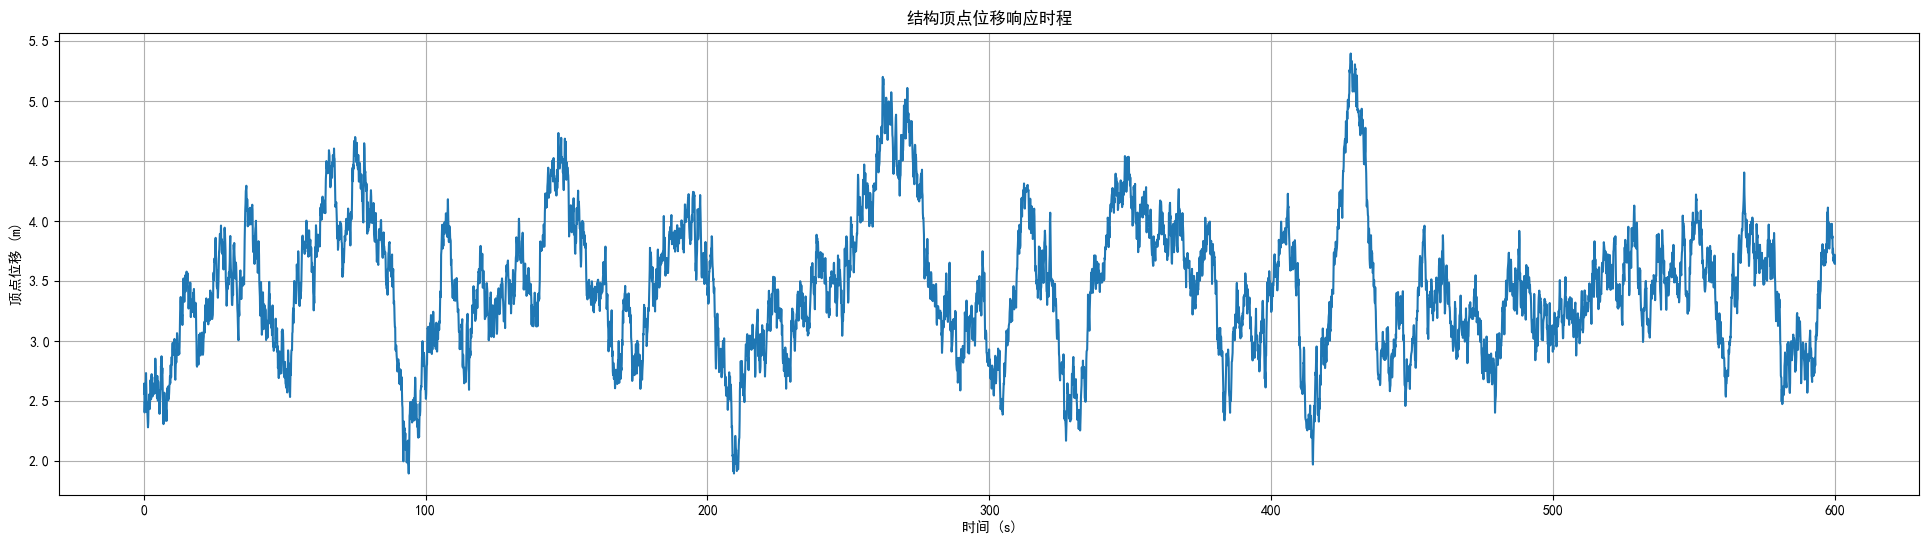

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path  # 更安全的路径处理

class WindResponseAnalyzer:
    def __init__(self):
        """初始化分析器并加载数据"""
        self._setup_plot_style()
        self.load_data()
        self.setup_structure_parameters()
        
    def _setup_plot_style(self):
        """配置绘图样式"""
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
    
    def load_data(self):
        """加载风速数据"""
        data_path = Path('./windData/windData.mat')
        try:
            sim_data = sio.loadmat(data_path, squeeze_me=True, struct_as_record=False)
            self.U = sim_data['U']
            self.Z = sim_data['Z']
            self.dt = sim_data['dt']
            self.t = sim_data['t']
        except Exception as e:
            raise FileNotFoundError(f"无法加载数据文件: {e}")

    def setup_structure_parameters(self):
        """设置结构参数"""
        # 基本参数
        self.H = 324.95  # 建筑物高度(m)
        self.B = 65.88   # 迎风面宽度(m)
        self.D = 35.5    # 横向宽度(m)
        self.T1 = 6.38   # 第一阶自振周期(s)
        
        # 高度分布参数
        self.h_ratio = np.linspace(0, 1, 11)  # 0到1均匀分布
        self.h_part_ratio = np.array([0, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
        
        # 振型和质量
        self.mode_shape = np.array([0.0000, 0.0137, 0.0558, 0.1277, 0.2424, 0.3503, 0.4629, 
                                  0.5903, 0.7309, 0.8700, 1.0000])
        self.mass = np.array([2500]*10 + [1500])  # 质量分布(ton)
        self.areas = self.B * self.D * self.h_part_ratio  # 各层受风面积

    def analyze_static_wind_load(self):
        """执行静态风荷载分析"""
        print("\n（1）静态风荷载计算结果：")
        
        # 初始化风荷载计算器
        windload = WindLoadCalculator(H=self.H, B=self.B, D=self.D, 
                                    mode_shape=self.mode_shape, terrain_type='C')
        
        # 计算静态风荷载
        static_loads = windload.calculate_static_wind_load()
        
        # 计算基底弯矩
        base_moment = 0
        heights = self.h_ratio * self.H  # 各层高度
        
        for i, (load, area) in enumerate(zip(static_loads, self.areas)):
            force = area * load  # 层风荷载(kN)
            moment_arm = heights[i]  # 弯矩臂
            base_moment += force * moment_arm
            
            print(f"\t高度 {self.h_ratio[i]:.1f}H:")
            print(f"\t\t风压：{load:.2f} kN/m²")
            print(f"\t\t风荷载：{force:.2f} kN")
            print(f"\t\t对基底弯矩贡献：{force * moment_arm:.2f} kN·m")
        
        print(f"总基底弯矩：{base_moment:.2f} kN·m")
        return static_loads, base_moment

    def analyze_dynamic_response(self):
        """执行动力时程分析"""
        print("\n（2）基于时域分析的结果:")
        
        # 初始化结构分析器
        sa = StructuralAnalysis(mass=self.mass, mode_shape=self.mode_shape, T1=self.T1)
        sa.set_wind_load(self.U, B=self.B, H=self.H)
        
        # 计算位移响应
        y = sa.calculate_displacement()
        y_top = y[:, -1]  # 顶点位移时程
        
        # 计算统计量
        g = 2.5  # 峰值因子
        y_mean = np.mean(y_top)
        y_std = np.std(y_top)
        y_max = y_mean + g * y_std
        
        # 打印结果
        print(f"\t顶点最大位移：{y_max:.4f} m")
        print(f"\t顶点平均位移：{y_mean:.4f} m")
        print(f"\t顶点位移标准差：{y_std:.4f} m")
        
        # 绘制时程曲线
        self._plot_response(y_top)
        return y_top

    def _plot_response(self, displacement):
        """绘制位移时程曲线"""
        plt.figure(figsize=(24, 6))
        plt.plot(self.t, displacement)
        plt.xlabel('时间 (s)')
        plt.ylabel('顶点位移 (m)')
        plt.title('结构顶点位移响应时程')
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    analyzer = WindResponseAnalyzer()
    analyzer.analyze_static_wind_load()
    analyzer.analyze_dynamic_response()